In [1]:
!pip install -q auto-gptq
!pip install -q --upgrade optimum
!pip install -q bitsandbytes
!pip install -q transformers==4.46.3

!pip install -q segment_anything
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done


In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    GenerationConfig,
)

processor = AutoProcessor.from_pretrained(
    "cyan2k/molmo-7B-D-bnb-4bit",
    trust_remote_code=True,
    device_map="auto",
    torch_dtype="auto",
)

model = AutoModelForCausalLM.from_pretrained(
    "cyan2k/molmo-7B-D-bnb-4bit",
    trust_remote_code=True,
    offload_folder="offload",
    torch_dtype="auto",
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def get_output(image, prompt="Describe this image."):
    """
    Function to get output from Molmo model given an image and a prompt.

    :param image: PIL image.
    :param prompt: User prompt.

    Returns:
        generated_text: Output generated by the model.
    """
    inputs = processor.process(images=[image], text=prompt)
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
        tokenizer=processor.tokenizer,
    )

    generated_tokens = output[0, inputs["input_ids"].size(1) :]
    generated_text = processor.tokenizer.decode(
        generated_tokens, skip_special_tokens=True
    )

    return generated_text

In [10]:
from PIL import Image
import requests
from io import BytesIO

url1 = "https://www.jeujouethique.com/media/catalog/product/cache/8/image/650x650/9df78eab33525d08d6e5fb8d27136e95/g/r/grands-cubes-gigognes-grimms-10370-2.jpg"

def test_get_output():
    # Load a sample image
    image_url = url1
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # load image and prompt
    inputs = processor.process(
        images=[image],
        text="Describe this image.",
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # Call the function

    result = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer,
    )

   # only get generated tokens; decode them to text
    generated_tokens = result[0, inputs["input_ids"].size(1) :]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # print the generated text
    print(generated_text)

# Run the test
test_get_output()

 The image features a stack of six colorful wooden blocks arranged in a pyramid-like formation on a white surface. The blocks are stacked from bottom to top in the following colors: red, orange, yellow, green, light blue, and purple. Each block is square-shaped and appears to be made of wood, with visible grain and a slightly shiny finish. The blocks are positioned with their corners facing the viewer, creating a sense of depth and perspective. The background is a plain white wall, and the lighting is even, highlighting the vibrant colors of the blocks. The overall composition is simple yet visually striking, with the colorful blocks creating a bold contrast against the stark white background.


📝 Molmo output:
  <points x1="58.0" y1="82.3" x2="58.3" y2="64.3" x3="58.5" y3="47.2" x4="60.5" y4="18.7" x5="61.0" y5="32.2" x6="61.3" y6="9.7" alt="cubes are on this picture">cubes are on this picture</points>
📍 Points détectés : [(58.0, 82.3), (58.3, 64.3), (58.5, 47.2), (60.5, 18.7), (61.0, 32.2), (61.3, 9.7)]


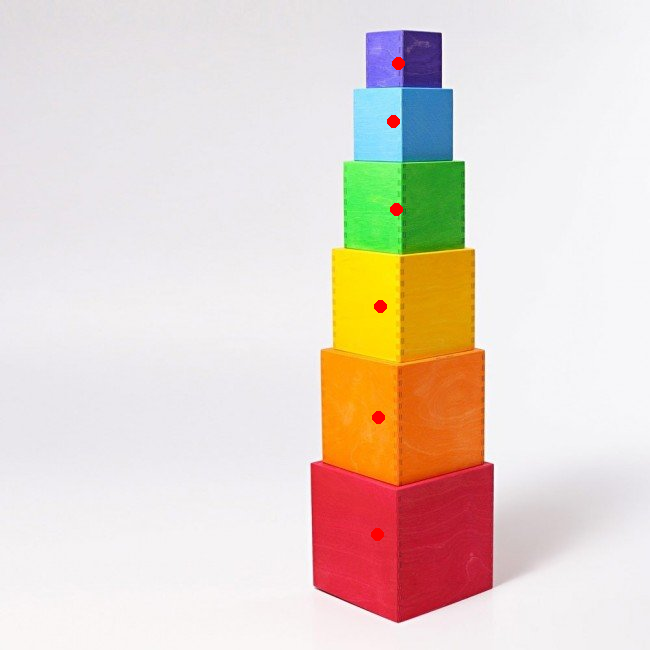

In [11]:
from PIL import Image, ImageDraw
import requests
from io import BytesIO
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, GenerationConfig
import re


def test_molmo_detection():
    # Charger une image de test
    image_url = url1
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Préparer les entrées
    inputs = processor.process(
        images=[image],
        text="How many cubes are on this picture? Mark them.",
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}
    inputs["images"] = inputs["images"].to(model.dtype)

    # Générer la réponse du modèle
    result = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
        tokenizer=processor.tokenizer,
    )

    generated_tokens = result[0, inputs["input_ids"].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print("📝 Molmo output:\n", generated_text)

    # Extraire les coordonnées à partir des balises <points ...>
    def extract_points(text):
        pattern = r'<points\s+(.*?)\s*alt='
        match = re.search(pattern, text)
        if not match:
            return []
        raw_coords = match.group(1)
        values = re.findall(r'[xy]\d+="([\d.]+)"', raw_coords)
        coords = list(map(float, values))
        return list(zip(coords[::2], coords[1::2]))

    points = extract_points(generated_text)
    print(f"📍 Points détectés : {points}")

    # Dessiner les points sur l’image
    def draw_points_on_image(image, points, color="red", radius=6):
      draw = ImageDraw.Draw(image)
      width, height = image.size
      for x, y in points:
          abs_x = x / 100 * width
          abs_y = y / 100 * height
          draw.ellipse((abs_x - radius, abs_y - radius, abs_x + radius, abs_y + radius), fill=color)
      return image

    annotated_image = draw_points_on_image(image.copy(), points)

    # Afficher l'image (pour notebook / Colab)
    from IPython.display import display
    display(annotated_image)

    return points

# Exécuter le test
points = test_molmo_detection()

In [25]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

image_url = url1
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

print("Points given by Molmo : ",points)

np_img = np.array(image)

print("Shape image numpy : ",np_img.shape)

image_width = np_img.shape[1]
image_height = np_img.shape[0]

points_scaled = [(
    x / 100 * image_width,
    y / 100 * image_height
) for (x, y) in points]

print("True points coordinates : ",points_scaled)
points_scaled = sorted(points_scaled, key=lambda x: x[1], reverse=True)
print("True points coordinates in order : ",points_scaled)

Points given by Molmo :  [(58.0, 82.3), (58.3, 64.3), (58.5, 47.2), (60.5, 18.7), (61.0, 32.2), (61.3, 9.7)]
Shape image numpy :  (650, 650, 3)
True points coordinates :  [(377.0, 534.9499999999999), (378.95, 417.95), (380.25, 306.8), (393.25, 121.55), (396.5, 209.3), (398.45, 63.04999999999999)]
True points coordinates in order :  [(377.0, 534.9499999999999), (378.95, 417.95), (380.25, 306.8), (396.5, 209.3), (393.25, 121.55), (398.45, 63.04999999999999)]


In [21]:
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np

image_url = url1
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

image = np.array(image)

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
predictor.set_image(image)

In [26]:
masks = []
for point in points_scaled:
    input_point = np.array([point])
    input_label = np.array([1])  # 1 = "foreground"
    masks_, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    masks.append(masks_[0])  # Ajout du masque de l'objet

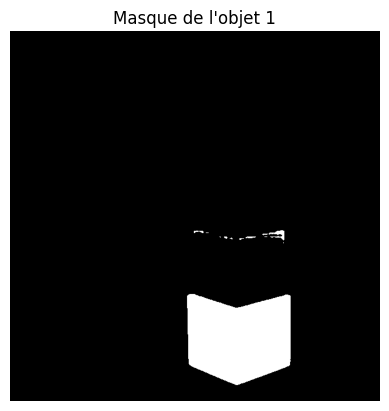

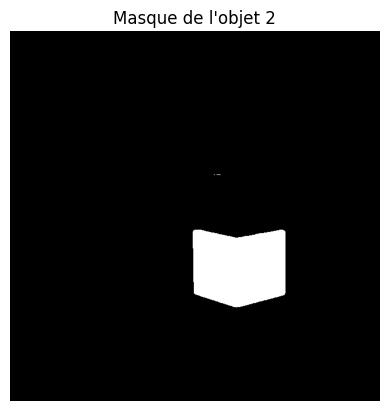

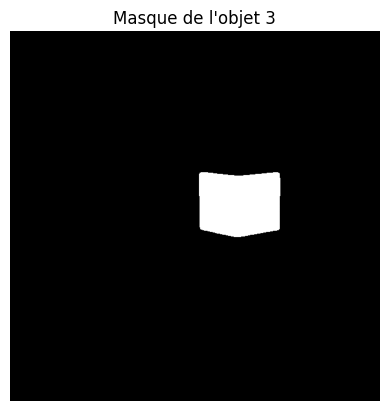

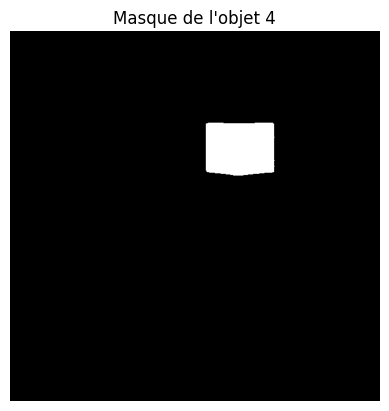

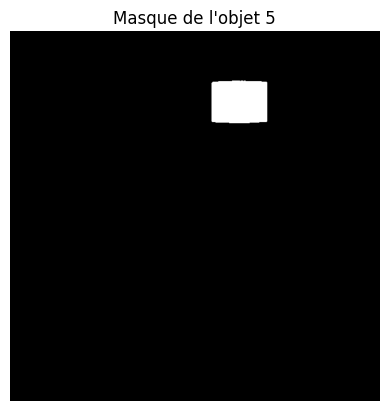

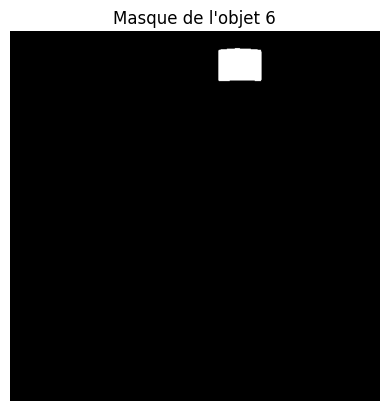

In [27]:
import matplotlib.pyplot as plt

for i, mask in enumerate(masks):
    plt.figure()
    plt.title(f"Masque de l'objet {i+1}")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

plt.show()

In [44]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [29]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting").to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

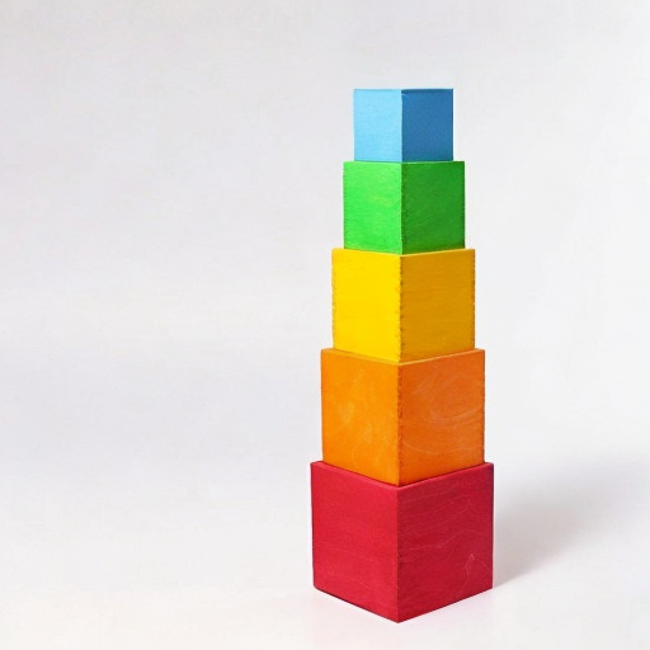

In [48]:
from PIL import Image
from IPython.display import display
import cv2

image_url = url1
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

original_size = [image_width,image_height]

positive_prompt = "empty background, no object, white color, realistic continuation of background"
negative_prompt = ("bad anatomy, bad proportions, blurry, cropped, deformed, disfigured, duplicate, "
                   "error, extra limbs, gross proportions, jpeg artifacts, long neck, low quality, lowres, "
                   "malformed, morbid, mutated, mutilated, out of frame, ugly, worst quality")

mask_array = masks[-1].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

result = pipe(
    prompt=positive_prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)

In [31]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

  0%|          | 0/50 [00:00<?, ?it/s]

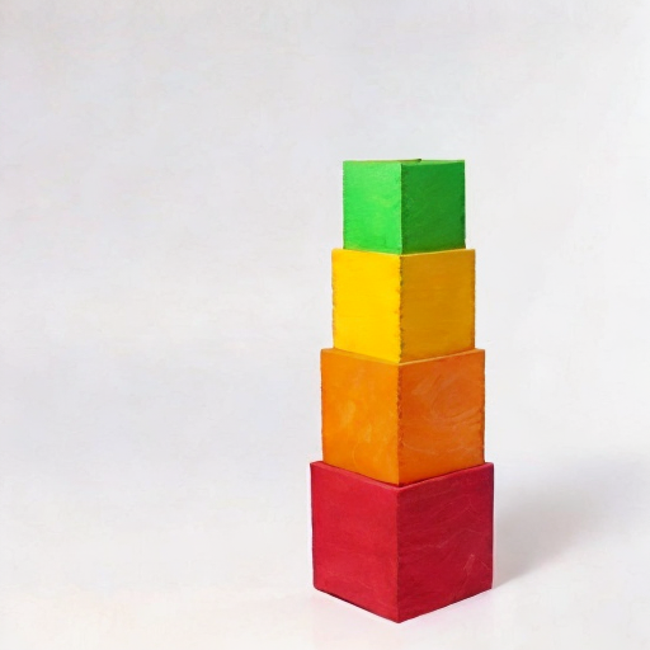

In [49]:
mask_array = masks[-2].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

positive_prompt = "empty background, no object, white color, realistic continuation of background"

result = pipe(
    prompt=positive_prompt,
    image=inpainted_image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)

  0%|          | 0/50 [00:00<?, ?it/s]

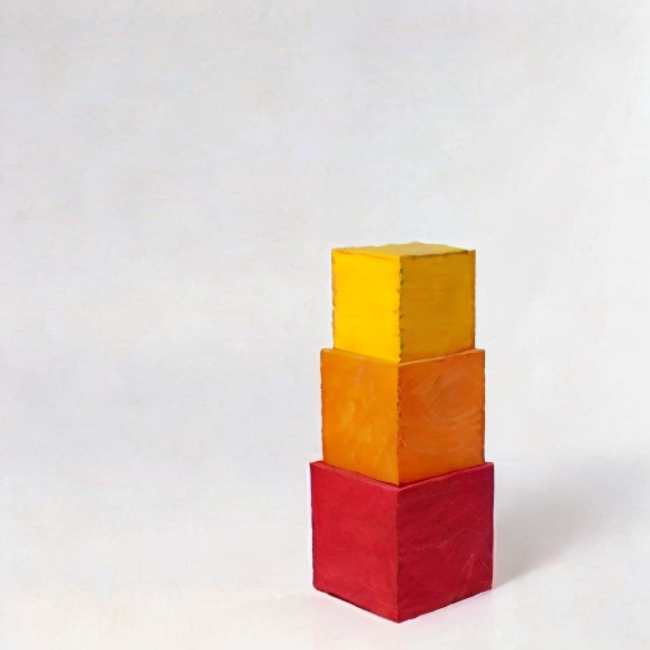

In [50]:
mask_array = masks[-3].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

positive_prompt = "empty background, no object, white color, realistic continuation of background, 4k, high quality"

result = pipe(
    prompt=positive_prompt,
    image=inpainted_image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)

  0%|          | 0/50 [00:00<?, ?it/s]

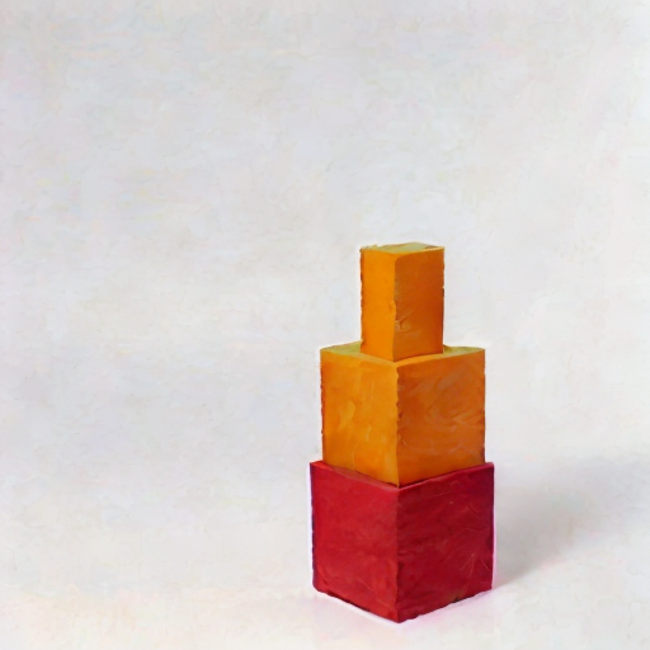

In [52]:
mask_array = masks[-4].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

positive_prompt = "empty background, no object, white color, realistic continuation of background, just backgrround, 4k, high quality"

result = pipe(
    prompt=positive_prompt,
    image=inpainted_image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)

In [ ]:
mask_array = masks[-5].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

positive_prompt = "empty background, no object, white color, realistic continuation of background, 4k, high quality"

result = pipe(
    prompt=positive_prompt,
    image=inpainted_image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)

In [ ]:
mask_array = masks[-6].astype(np.uint8) * 255
mask_array_dilated = cv2.dilate(mask_array, np.ones((15, 15), np.uint8), iterations=1)
mask_image = Image.fromarray(mask_array_dilated).convert("L")

positive_prompt = "a realistic continuation of the background, 4k, high quality"

result = pipe(
    prompt=positive_prompt,
    image=inpainted_image,
    mask_image=mask_image,
    guidance_scale=7.5,
    num_inference_steps=50,
)
inpainted_image = result.images[0].resize(original_size)
display(inpainted_image)